In [1]:
import os
import sys
import glob
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (22,8)
np.random.seed(30)
sns.set_theme(style="darkgrid")
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv("../data/air-quality-index.csv")
df.tail(3)

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
420765,35062,2017,2,28,21,14.0,28.0,4.0,38.0,500.0,54.0,10.8,1014.2,-13.3,0.0,NW,1.1,Wanshouxigong
420766,35063,2017,2,28,22,12.0,23.0,4.0,30.0,400.0,59.0,10.5,1014.4,-12.9,0.0,NNW,1.2,Wanshouxigong
420767,35064,2017,2,28,23,13.0,19.0,4.0,38.0,600.0,49.0,8.6,1014.1,-15.9,0.0,NNE,1.3,Wanshouxigong


In [3]:
df = df[['PM2.5', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'DEWP']]

In [4]:
X, y = df.iloc[:,1:], df['PM2.5'].values
df.fillna(df.mean(), inplace=True)

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y.reshape(-1,1), test_size = 0.2, random_state = 30)

y_train

array([[79.79342813],
       [12.        ],
       [87.        ],
       ...,
       [20.        ],
       [58.        ],
       [75.        ]])

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
y_train = scaler.fit_transform(y_train)
y_test = scaler.fit_transform(y_test)

N, D = X_train.shape

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(4, input_shape=(D,)),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(1)
])

In [8]:
model.compile(optimizer=tf.keras.optimizers.SGD(0.001, 0.9), loss = 'mse')

In [9]:
def schedule(epoch, lr):
    if epoch >=0 :
        return 0.0001
    return 0.001
scheduler = tf.keras.callbacks.LearningRateScheduler(schedule)

In [10]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 10, workers=5, callbacks=[scheduler])

Epoch 1/10
10520/10520 [==============================] - 15s 1ms/step - loss: 0.3387 - val_loss: 0.3273
Epoch 2/10
10520/10520 [==============================] - 19s 2ms/step - loss: 0.3288 - val_loss: 0.3257
Epoch 3/10
10520/10520 [==============================] - 18s 2ms/step - loss: 0.3282 - val_loss: 0.3250
Epoch 4/10
10520/10520 [==============================] - 15s 1ms/step - loss: 0.3280 - val_loss: 0.3258
Epoch 5/10
10520/10520 [==============================] - 15s 1ms/step - loss: 0.3280 - val_loss: 0.3251
Epoch 6/10
10520/10520 [==============================] - 15s 1ms/step - loss: 0.3280 - val_loss: 0.3258
Epoch 7/10
10520/10520 [==============================] - 16s 1ms/step - loss: 0.3279 - val_loss: 0.3265
Epoch 8/10
10520/10520 [==============================] - 16s 1ms/step - loss: 0.3280 - val_loss: 0.3254
Epoch 9/10
10520/10520 [==============================] - 16s 2ms/step - loss: 0.3279 - val_loss: 0.3248
Epoch 10/10
10520/10520 [==============================

In [11]:
pred = model.predict(X_test)

<AxesSubplot:>

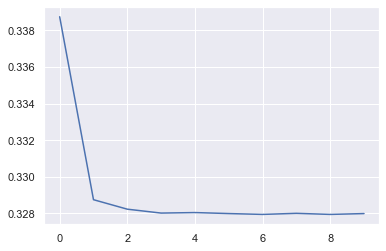

In [12]:
sns.lineplot(data=history.history['loss'])

In [13]:
model.evaluate(X_test, y_test)

2630/2630 [==============================] - 2s 806us/step - loss: 0.3261


0.3260927200317383

In [14]:
pred

array([[ 0.34864858],
       [ 1.0179278 ],
       [ 1.6767551 ],
       ...,
       [ 0.7613809 ],
       [-0.15243812],
       [ 0.26536873]], dtype=float32)

In [15]:
model.save("air.h5")

In [16]:
lm = tf.keras.models.load_model("air.h5")
print(lm.layers)

[<tensorflow.python.keras.layers.core.Dense object at 0x000001AF37ACFD48>, <tensorflow.python.keras.layers.core.Dense object at 0x000001AF3CFB2388>, <tensorflow.python.keras.layers.core.Dense object at 0x000001AF24BEC848>, <tensorflow.python.keras.layers.core.Dense object at 0x000001AF3CFB8C08>]


In [17]:
lm.evaluate(X_test, y_test)

2630/2630 [==============================] - 2s 787us/step - loss: 0.3261


0.3260927200317383